# IAM hands-on session from the 2019 AERE pre-conference Workshop

## 3. Modifying parameters

This section will show you how to run a model with modified input parameter values.

We will show examples for FUND and DICE2010, so we load both models.

In [1]:
using Mimi, MimiFUND, MimiDICE2010

Our first example involves FUND. As a first step, we are constructing two instances of the FUND model. We will later modify an input parameter in only one of the copies, so that we can easily compare the effect of the modified parameter.

In [2]:
m_fund1 = MimiFUND.get_model()
m_fund2 = MimiFUND.get_model();

To modify the `climatesensitivity` parameter in the `climatedynamics` component of the second instance of FUND (`m_fund2`) we call the `set_param!` function with the new value for climate sensitivty we want to use (in our example `4.5`).

In [3]:
set_param!(m_fund2, :climatedynamics, :climatesensitivity, 4.5)

We now run both instances of the model, the original `m_fund1` and the modified `m_fund2`:

In [4]:
run(m_fund1)
run(m_fund2)

We are now going to construct some more sophisticated plots using the [VegaLite.jl](https://github.com/queryverse/VegaLite.jl) plotting package. Documentation for that plotting package can be found [here](https://www.queryverse.org/VegaLite.jl/stable/). The first step, as always, is to load that package into our currenty session.

In [5]:
using VegaLite

We create a new plot by calling the `@vlplot` macro. We are passing some configuration information as arguments here. In particular we want to make sure that the two panels of our plot that we are going to add share one `y` axis. Next we add two horizontally concatenated plots. Adding those two plots is done with the `+` operator, and we concatenate the two plots we get from calls to `Mimi.plot` by placing them inside square brackets as `[p1 p2]`.

We can clearly see how the higher climate sensitivity value in the second model instance leads to a significantly higher warming.

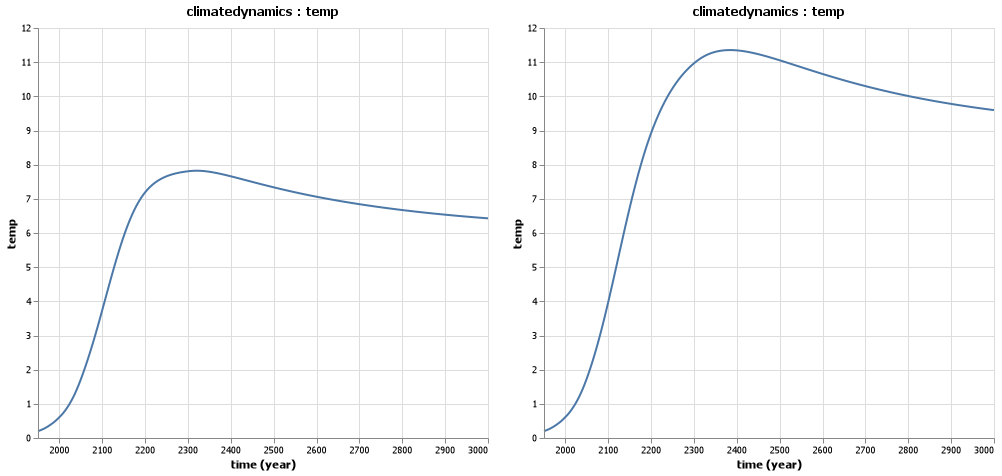

In [6]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_fund1, :climatedynamics, :temp) Mimi.plot(m_fund2, :climatedynamics, :temp)]

Our next example involves the DICE2010 model. We again load two instances of the model so that we can modify only one instance (`m_dice1`) and can then compare it with an unmodified version instance (`m_dice2`).

In [7]:
m_dice1 = MimiDICE2010.get_model()
m_dice2 = MimiDICE2010.get_model();

In this example we want to alter the default emission control rate time series in DICE. The name of that parameter is `MIU` in the component `emissions`. Because `MIU` is not a scalar parameter value, but instead a vector of values, we need to pass the vector of values we want to use to the `set_param!` function. In our example we create a vector with 60 elements that all have the value `0.5` by calling `fill(0.5, 60)`. For DICE this means that business as usual emissions are reduced by 50% in each time period.

In [8]:
set_param!(m_dice2, :emissions, :MIU, fill(0.5, 60))

After setting this parameter in the second instance of the model, we can run both model instances again.

In [9]:
run(m_dice1)
run(m_dice2)

We can again plot a key output variable, in this case global average temperature increase`TATM`, from both models to compare the effect of our modification.

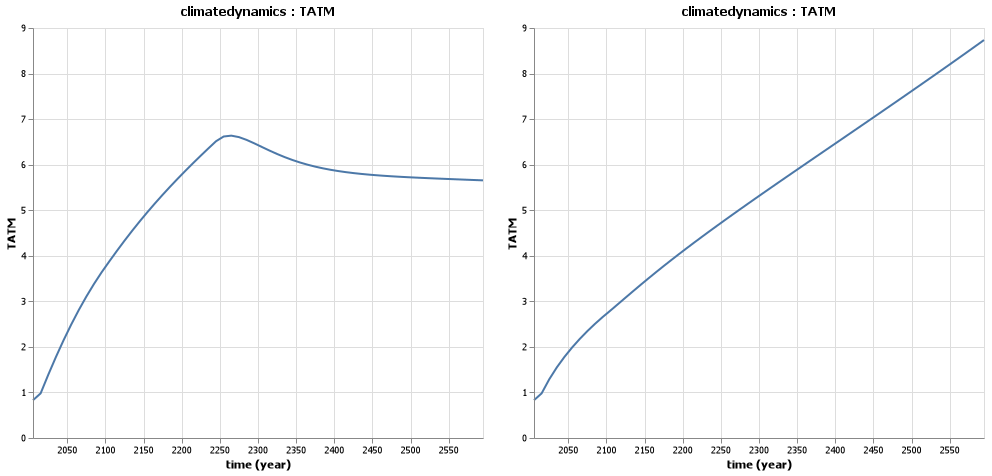

In [10]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_dice1, :climatedynamics, :TATM) Mimi.plot(m_dice2, :climatedynamics, :TATM)]

The results look strange though! Our model with the 50% emission control policy in place has lower temperatures in the first half of the model runs, but then gets much warmer than the model without the policy! Something is wrong here, so let's try to figure out what the problem is.

As a first step, let's look at CO2 concentrations in the two models, maybe we can pin down the problem that way:

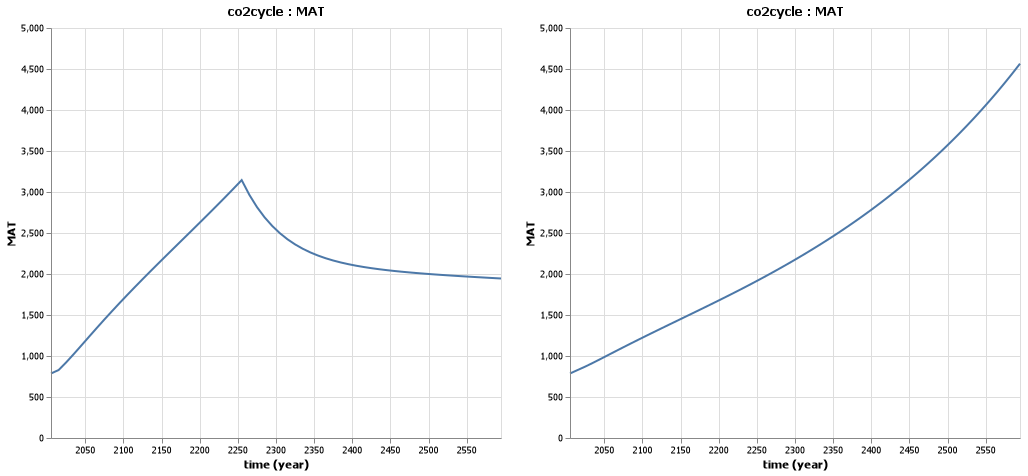

In [11]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_dice1, :co2cycle, :MAT) Mimi.plot(m_dice2, :co2cycle, :MAT)]

Ah, in our base run, concentrations fall quite dramatically starting in 2250, even without any climate policy in place, and that doesn't seem to be the case in our policy run.

Let's next look at the actual emission control run numbers that are used in the two runs:

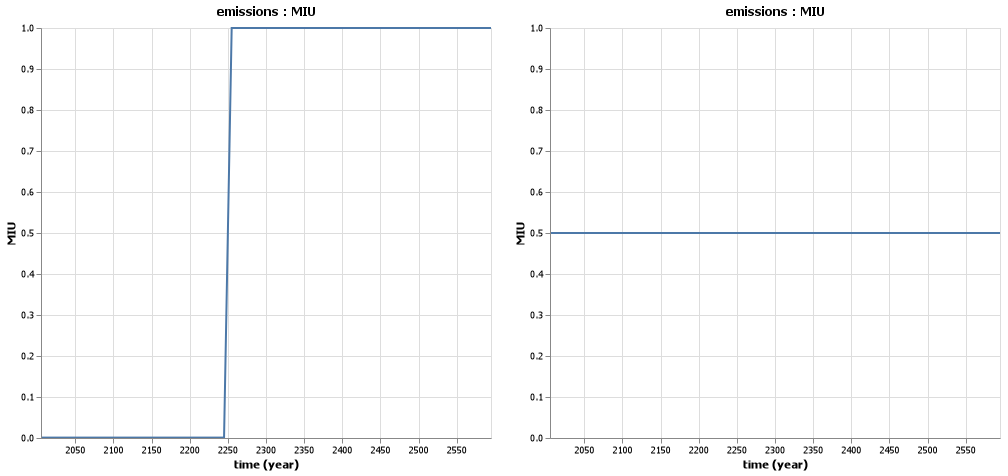

In [12]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_dice1, :emissions, :MIU) Mimi.plot(m_dice2, :emissions, :MIU)]

We can now see that in the base run, emissions are controlled at a 100% after 2250, but they are controlled at 50% in all years in the second run. This is an example where we actually need to understand the structure of the underlying model: in DICE there is an assumption that at some point a backstop technology appears that makes emission reductions so cheap that emission are completely controlled, even without a climate policy. That is occuring in the base run, but not in our policy scenario. Effectively we have constructed a policy scenario that is not very useful because it ignores a key feature of DICE.

Let's try to do better, and run with a policy scenario where we set the emission control rate to 50% for the first 25 time periods (each time period in DICE is 10 years long), and then we set the emission control rate to 100%, as is the case in the base scenario.

We can construct such a time series by concatenating two vectors with the `[a; b]` syntax from Julia.

We set this new parameter value, and then rerun the second model instance.

In [13]:
set_param!(m_dice2, :emissions, :MIU, [fill(0.5, 25); fill(1., 35)])
run(m_dice2)

Let's first compare the emission conrol rates we are now using for our two models:

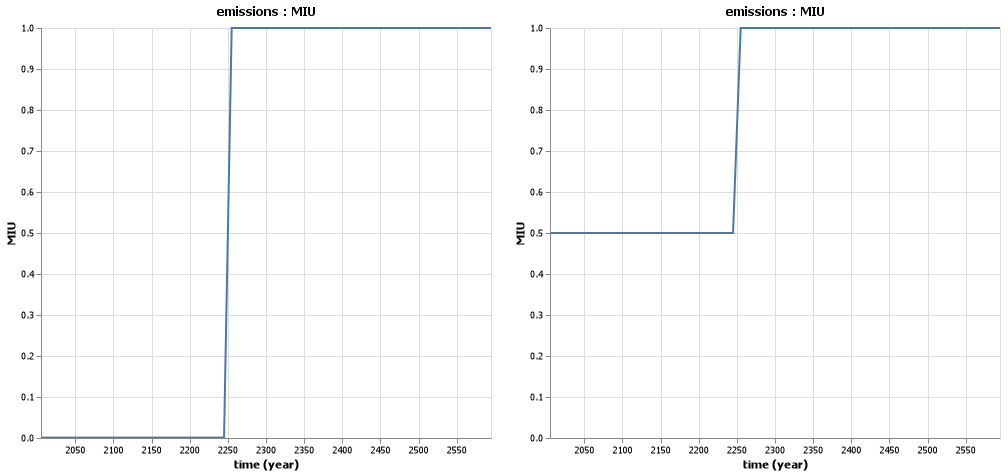

In [14]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_dice1, :emissions, :MIU) Mimi.plot(m_dice2, :emissions, :MIU)]

This looks much more reasonable! Let's see what the CO2 concentrations look like now.

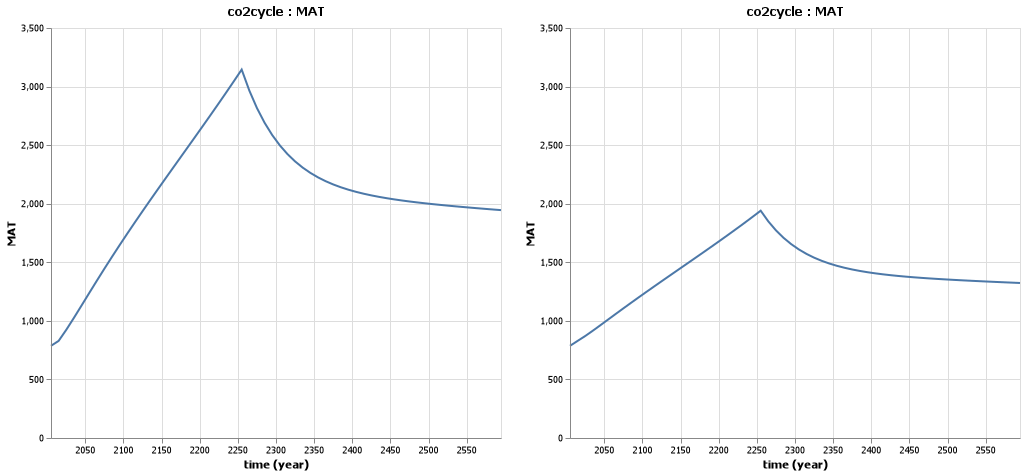

In [15]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_dice1, :co2cycle, :MAT) Mimi.plot(m_dice2, :co2cycle, :MAT)]

This is more in line with what we would expect: our policy scenario now has lower CO2 concentrations at all time periods.

Our final comparison is on global temperature, and those numbers now also make sense:

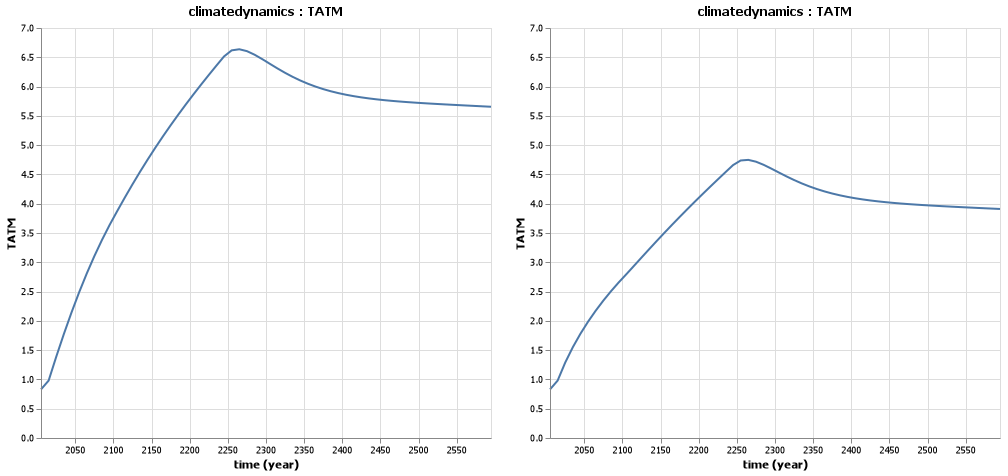

In [16]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_dice1, :climatedynamics, :TATM) Mimi.plot(m_dice2, :climatedynamics, :TATM)]